In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


# Configure the hyperparameters

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 256  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 128
num_heads = 4
scale = projection_dim ** -0.5
dropout=0.1
epsilon=1e-6
transformer_units = [
                     projection_dim * 2,
                     projection_dim,
                    ]  # Size of the transformer layers
num_encoder_transformer_layers = 4
num_decoder_transformer_layers = 4
input_shape = (384, 384, 3)
num_classes = 5

In [4]:
DataPreprocessing = keras.Sequential(
                                     [
                                        layers.experimental.preprocessing.Normalization(),
                                        layers.experimental.preprocessing.Resizing(image_size, image_size,interpolation='bilinear'),
                                     ],
                                     name = 'data_preprocessing',
                                    )
# Compute the mean and the variance of the training data for normalization.
DataPreprocessing.layers[0].adapt(x_train)

# Implement Multi Layer Perceptron (MLP)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implement Patch creation as a layer

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
                                            images=images,
                                            sizes=[1, self.patch_size, self.patch_size, 1],
                                            strides=[1, self.patch_size, self.patch_size, 1],
                                            rates=[1, 1, 1, 1],
                                            padding="VALID",
                                          )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [tf.shape(patches)[0], patches.shape[1] * patches.shape[2], patch_dims])

        return patches


In [7]:
def show_patches(x_train, image_size, patch_size):
    
    image = x_train[np.random.choice(range(x_train.shape[0]))]

    plt.figure(figsize=(4, 4))
    plt.imshow(image.astype("uint8"))
    plt.axis("off")

    resized_image = tf.image.resize( tf.convert_to_tensor([image]), size=(image_size, image_size) )
    patches = Patches(patch_size)(resized_image)
    
    print(f"Input Image size: {image_size} X {image_size} X {resized_image.shape[-1]} ")
    print(f"Patch size: {patch_size} X {patch_size} ")
    print(f"Patch shape: {patches.shape} ")
    print(f"Number of Patches per image: {patches.shape[1]}")
    print(f"Number of Elements per patch: {patches.shape[-1]}")

    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(4, 4))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        plt.imshow(patch_img.numpy().astype("uint8"))
        plt.axis("off")

Input Image size: 256 X 256 X 3 
Patch size: 8 X 8 
Patch shape: (1, 1024, 192) 
Number of Patches per image: 1024
Number of Elements per patch: 192


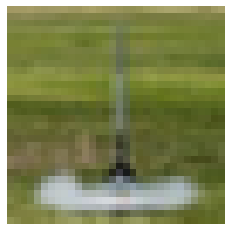

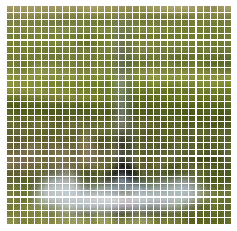

In [8]:
show_patches(x_train, image_size, patch_size)

# Implement Patch encoding layer

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding( input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


# Build  Transfomer Layer 

In [10]:
class TransfomerLayer(layers.Layer):
    
    def __init__(self, num_transformer_layers, projection_dim, num_heads, transformer_units, dropout, epsilon):
        super(TransfomerLayer, self).__init__()
        self.num_transformer_layers = num_transformer_layers
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.transformer_units = transformer_units
        self.dropout = dropout
        self.epsilon = epsilon
        
    def call (self, x):

        # Create multiple layers of the Transformer block.
        for _ in range(self.num_transformer_layers):
            # Layer normalization 1.
            x1 = layers.LayerNormalization(epsilon= self.epsilon)(x)
            # Create a multi-head attention layer.
            attention_output = layers.MultiHeadAttention(
                                      num_heads=self.num_heads, key_dim=self.projection_dim, dropout=self.dropout
                                                        )(x1, x1)
            # Skip connection 1.
            x2 = layers.Add()([attention_output, x])
            # Layer normalization 2.
            x3 = layers.LayerNormalization(epsilon=self.epsilon)(x2)
            # MLP.
            x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=self.dropout)
            # Skip connection 2.
            x = layers.Add()([x3, x2])
            
        return x


In [11]:
class Encoder(layers.Layer):

    def __init__(self, num_transformer_layers, projection_dim, num_heads, transformer_units, dropout, epsilon):
        super(Encoder, self).__init__()
        
        self.num_transformer_layers =  num_transformer_layers
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.transformer_units = transformer_units
        self.dropout = dropout
        self.epsilon = epsilon
        
        self.transformerLayer = TransfomerLayer(self.num_transformer_layers, self.projection_dim, self.num_heads,
                                                self.transformer_units,  self.dropout,  self.epsilon )

    def call(self, x):


        x = self.transformerLayer(x)

        return x

In [12]:
class MaskTransformer(layers.Layer):

    def __init__(self, num_classes, num_transformer_layers, projection_dim, num_heads, transformer_units, dropout, epsilon):
        super(MaskTransformer, self).__init__()
        
        self.num_classes = num_classes
        self.num_transformer_layers =  num_transformer_layers
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.transformer_units = transformer_units
        self.dropout = dropout
        self.epsilon = epsilon
        
        self.cls_tokens = tf.random.normal((1, self.num_classes, self.projection_dim))
        self.transformerLayer = TransfomerLayer(self.num_transformer_layers, self.projection_dim, self.num_heads,
                                                self.transformer_units,  self.dropout,  self.epsilon )

    def call(self, x):

        b = tf.shape(x)[0]#x.shape[0]
        cls_tokens = tf.repeat(self.cls_tokens,[b], axis=0) 
        x = layers.concatenate([cls_tokens,x ], axis=1)
        x = self.transformerLayer(x)
        c = x[:, :self.num_classes]
        z = x[:, self.num_classes:]
        return z, c

In [13]:
class Upsample(layers.Layer):

    def __init__(self, image_size, patch_size):
        super(Upsample, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.p = self.image_size // self.patch_size
        self.upsample = layers.UpSampling2D( size=(self.patch_size, self.patch_size), interpolation='bilinear')

        
    def call(self, x):
           
        x = tf.reshape(x, (tf.shape(x)[0], self.p,  self.p, x.shape[2]))
        x = self.upsample(x)
        
        return x

In [14]:
class Decoder(layers.Layer):

    def __init__(self, num_classes, image_size, patch_size, num_transformer_layers,
                 projection_dim, num_heads, transformer_units, dropout, epsilon, scale):
        
        super(Decoder, self).__init__()
        
        self.num_classes = num_classes
        self.image_size = image_size
        self.patch_size = patch_size

        self.num_transformer_layers =  num_transformer_layers
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.transformer_units = transformer_units
        self.dropout = dropout
        self.epsilon = epsilon
        self.scale = scale

        self.maskTransformer = MaskTransformer(self.num_classes, self.num_transformer_layers,  self.projection_dim,
                                                self.num_heads,  self.transformer_units,  self.dropout, self.epsilon)
        
        self.upsample =  Upsample(self.image_size, self.patch_size)

    def call(self, x):

        z, c = self.maskTransformer (x)
        masks = z @ tf.transpose(c, perm=[0, 2, 1])
        masks = tf.nn.softmax(masks / self.scale, axis=-1)
        upsapled_masks = self.upsample(masks)
        
        return upsapled_masks

In [15]:
def create_model(input_shape, image_size,  patch_size, num_patches, num_classes, num_encoder_transformer_layers,
                 num_decoder_transformer_layers, projection_dim, num_heads,
                 transformer_units, dropout, epsilon, scale
                ):
    
    inputs = layers.Input(shape=input_shape)
    print('Input Shape :',inputs.shape)
    
    # Augment data.
    data_preprocessing = DataPreprocessing(inputs)
    print('Augmented Shape: ',data_preprocessing.shape)

    # Create patches.
    patches = Patches(patch_size)(data_preprocessing)
    print('Patch Shape: ',patches.shape)
    
    # Encoded patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    print('Encoded patch Shape: ', encoded_patches.shape)
    
     # Create Encoder.
    encoder = Encoder(num_encoder_transformer_layers, projection_dim, num_heads, transformer_units, dropout, epsilon)(encoded_patches)
    print('Encoder output Shape: ', encoder.shape)

    # Create Decoder.
    decoder = Decoder(num_classes, image_size, patch_size, num_decoder_transformer_layers,
                      projection_dim, num_heads, transformer_units, dropout, epsilon, scale)(encoder)
    print('Decoder output Shape: ', decoder.shape)
    
    model = keras.Model(inputs=inputs, outputs=decoder)
    return model

In [17]:
model = create_model(input_shape, image_size,  patch_size, num_patches, num_classes,
                     num_encoder_transformer_layers, num_decoder_transformer_layers,
                     projection_dim, num_heads,transformer_units, dropout, epsilon, scale
                     )

Input Shape : (None, 384, 384, 3)
Augmented Shape:  (None, 256, 256, 3)
Patch Shape:  (None, 1024, 192)
Encoded patch Shape:  (None, 1024, 128)
Encoder output Shape:  (None, 1024, 128)
Decoder output Shape:  (None, 256, 256, 5)
